In [1]:
import warnings
warnings.simplefilter(action='ignore')#, category=FutureWarning

In [2]:
import pandas as pd
import numpy as np
from time import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN

# Machine Learning algorithms:

Load dataset

In [3]:
dfHeart = pd.read_csv("./datasets/heart_conditionalMeanImputation.csv")

One-encoding to use categorical variables in ML models.

In [4]:
from sklearn.preprocessing import OneHotEncoder

# Create an instance of the OneHotEncoder class
onehot_encoder = OneHotEncoder(sparse_output=True)

# Encode the 'Sex', 'ST_Slope', 'ChestPainType', 'ExerciseAngina' and 'RestingECG' columns using one-hot encoding
onehot_sparse = onehot_encoder.fit_transform(dfHeart[['Sex', 'ST_Slope','ChestPainType','ExerciseAngina','RestingECG']])
# Convert the encoded data to a pandas DataFrame
onehot_df = pd.DataFrame.sparse.from_spmatrix(onehot_sparse, columns=onehot_encoder.get_feature_names_out(['Sex', 'ST_Slope','ChestPainType','ExerciseAngina','RestingECG']))

# Concatenate the one-hot encoded data with the original data
dfHeart = pd.concat([onehot_df,dfHeart], axis=1)

# Drop the original 'Sex', 'ST_Slope', 'ChestPainType', 'ExerciseAngina' and 'RestingECG' columns
dfHeart = dfHeart.drop(['Sex', 'ST_Slope', 'ChestPainType', 'ExerciseAngina', 'RestingECG'], axis=1)

Train and test splitting

In [5]:
from sklearn.model_selection import train_test_split
# Splitting train and test 0.75/0.25
X = dfHeart.drop('HeartDisease', axis=1)
y = dfHeart['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

Techniques to balance the data do not increase the performance of the metrics

In [6]:
# smote = SMOTE(k_neighbors = 4, random_state=1)
# X_train, y_train = smote.fit_resample(X_train, y_train)
# ros = RandomOverSampler(random_state=0,shrinkage=0.8)
# X_train, y_train = ros.fit_resample(X_train, y_train)
# ada = ADASYN(random_state=0, n_neighbors=2)
# X_train, y_train = ada.fit_resample(X_train, y_train)

Not heart disease (y = 0)

In [7]:
len(y_train)-sum(y_train)

318.0

Heart disease (y = 1)

In [8]:
sum(y_train)

370.0

In [9]:
# Plot confusion matrices
classes = ['Not heart disease','Heart disease']
def plot_confusionmatrix(y_train_pred,y_train,dom): 
    print(str(dom)+" confusion matrix")
    cf_tree = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf_tree,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Greens', fmt='g')
    plt.tight_layout()
    plt.show()

In [10]:
# Plot roc curves
def plot_roccurve(y_test,X_test,clf):
    y_score = clf.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_score, drop_intermediate=False, pos_label = 1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

## Decision tree

In [11]:
# Imports for decision tree
from sklearn import tree

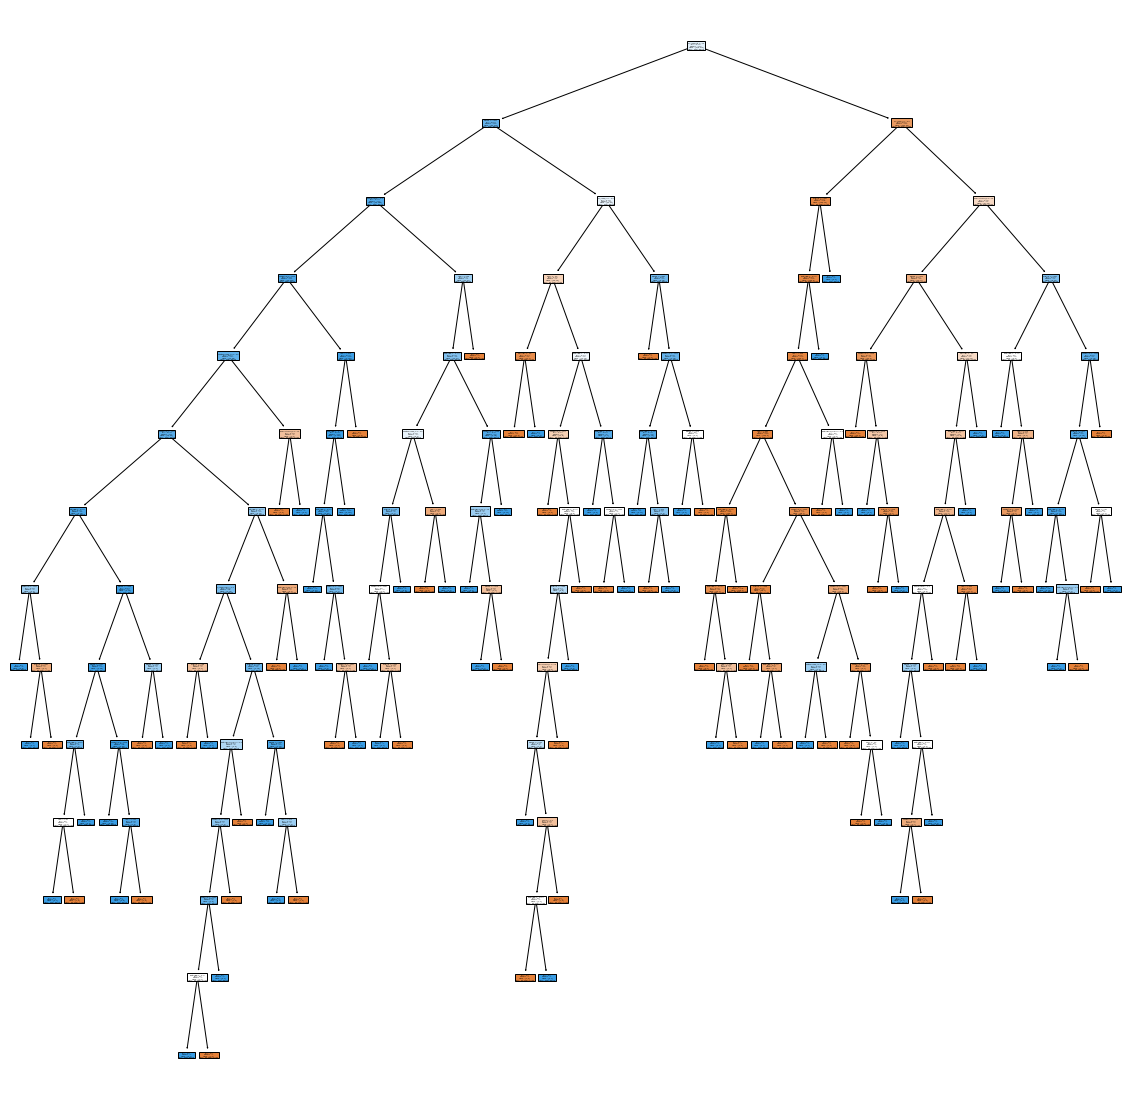

In [12]:
# Building a complete tree
clf_tree = tree.DecisionTreeClassifier(random_state=0)
clf_tree.fit(X_train,y_train)
y_train_pred = clf_tree.predict(X_train)
y_test_pred = clf_tree.predict(X_test)
# Plotting tree
plt.figure(figsize=(20,20))
features = dfHeart.columns
tree.plot_tree(clf_tree,feature_names=features,class_names=classes,filled=True)
plt.show()

In [13]:
# Calculating train and test score (Overfitting)
print("Train score: "+str(accuracy_score(y_train_pred,y_train)))
print("Test score: "+str(accuracy_score(y_test_pred,y_test)))

Train score: 1.0
Test score: 0.8347826086956521


In [14]:
t0 = time()
print("Fitting the classifier to the training set...")
# 10-fold cv with different parameters
params = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],#, 9, 10
    'min_samples_split': [2, 3, 4], #2, 3, 4
     'min_samples_leaf': [1, 2, 3, 4, 5, 6],
    'criterion': ['gini', 'entropy','log_loss'],
    'splitter': ['best', 'random'],
    'max_features': ['sqrt', 'log2']
}
clf_temp = tree.DecisionTreeClassifier(class_weight = 'balanced', random_state=0)
grid_tree = GridSearchCV(estimator=clf_temp,param_grid=params,cv=10)
grid_tree.fit(X_train,y_train)
clf_pruned_tree = grid_tree.best_estimator_
print("Elapsed time: %0.3fs"%(time() - t0))
print("Best estimator found by grid search:")
print(grid_tree.best_params_)

Fitting the classifier to the training set...
Elapsed time: 264.357s
Best estimator found by grid search:
{'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}


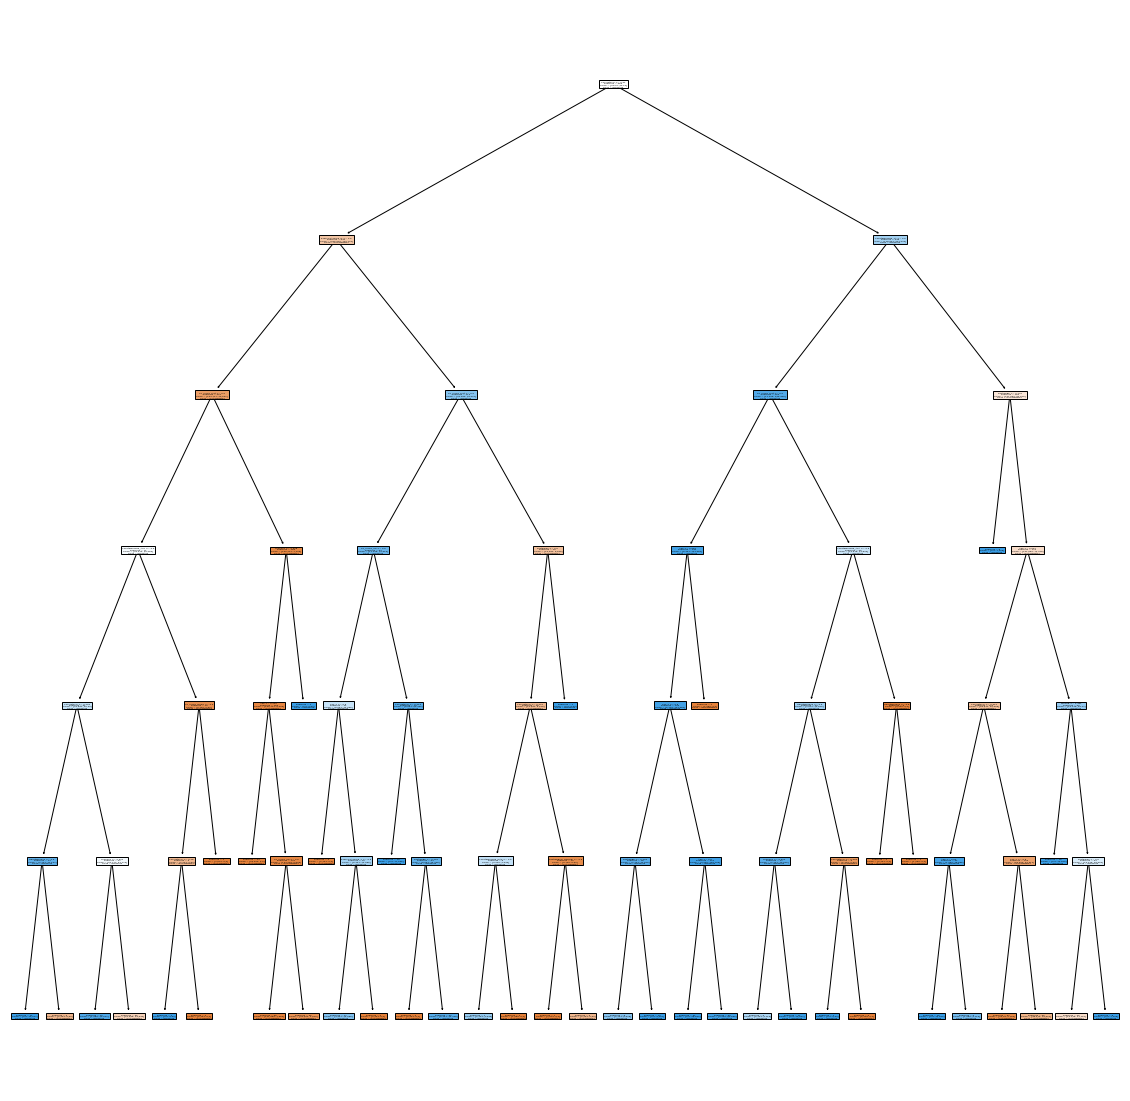

In [15]:
# Plotting pruned tree
plt.figure(figsize=(20,20))
features = dfHeart.columns
classes = ['Not diabetes','Diabetes']
tree.plot_tree(clf_pruned_tree,feature_names=features, class_names=classes,filled=True, impurity=False)
plt.show()

In [16]:
#Fitting with the best parameters
clf_pruned_tree.fit(X_train,y_train)
#Predicting
y_train_pred = clf_pruned_tree.predict(X_train)
y_test_pred = clf_pruned_tree.predict(X_test)

print("Train score: "+str(accuracy_score(y_train_pred,y_train)))
print("Test score: "+str(accuracy_score(y_test_pred,y_test)))

Train score: 0.8822674418604651
Test score: 0.8260869565217391


Train confusion matrix


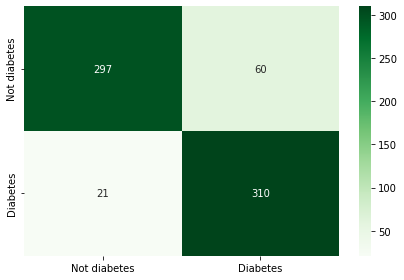

Test confusion matrix


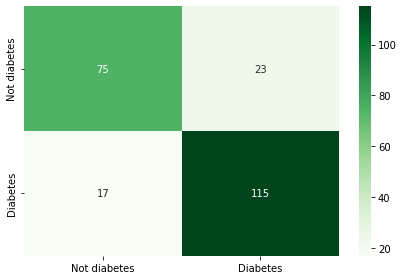

In [17]:
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

In [18]:
print('Train classification report')
print(classification_report(y_train, y_train_pred, target_names=classes))

print('Test classification report')
print(classification_report(y_test, y_test_pred, target_names=classes))

Train classification report
              precision    recall  f1-score   support

Not diabetes       0.83      0.93      0.88       318
    Diabetes       0.94      0.84      0.88       370

    accuracy                           0.88       688
   macro avg       0.88      0.89      0.88       688
weighted avg       0.89      0.88      0.88       688

Test classification report
              precision    recall  f1-score   support

Not diabetes       0.77      0.82      0.79        92
    Diabetes       0.87      0.83      0.85       138

    accuracy                           0.83       230
   macro avg       0.82      0.82      0.82       230
weighted avg       0.83      0.83      0.83       230



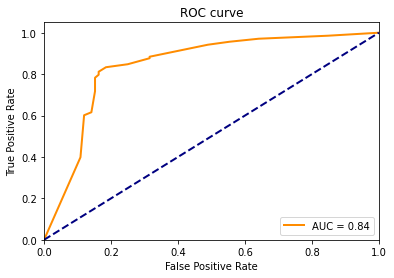

In [19]:
plot_roccurve(y_test,X_test,clf_pruned_tree)

## k nearest neighbors (k-NN)

In [20]:
from sklearn.neighbors import KNeighborsClassifier

In [21]:
# Training k nearest neighbors (k-NN)
t0 = time()
print("Fitting the classifier to the training set...")
# If the dataset is small it is recommended small values of neighbours
param_grid = {'n_neighbors': [2,3,4,5,6], #6,7
              'weights': ['uniform', 'distance'],
              'algorithm': ['ball_tree', 'kd_tree', 'brute'],
              'p': [1, 2]}
clf_temp = KNeighborsClassifier()
grid = GridSearchCV(estimator = clf_temp, param_grid = param_grid, cv=10)
grid.fit(X_train, y_train)
clf_KNN = grid.best_estimator_

print("Elapsed time: %0.3fs"%(time() - t0))
print("Best estimator found by grid search:")
print(grid.best_params_)

Fitting the classifier to the training set...
Elapsed time: 13.382s
Best estimator found by grid search:
{'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


In [22]:
y_train_pred = clf_KNN.predict(X_train)
y_test_pred = clf_KNN.predict(X_test)
print("Train score: "+str(accuracy_score(y_train_pred,y_train)))
print("Test score: "+str(accuracy_score(y_test_pred,y_test)))

Train score: 0.8822674418604651
Test score: 0.7956521739130434


Train confusion matrix


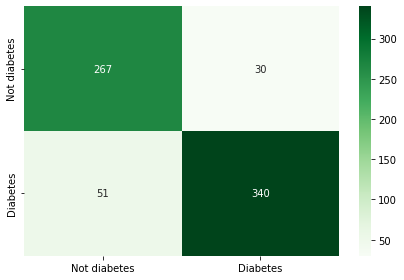

Test confusion matrix


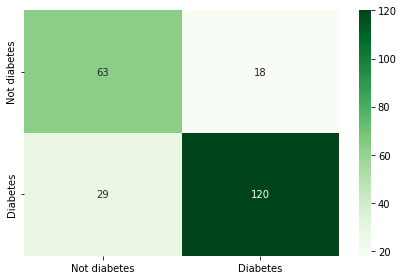

In [23]:
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

In [24]:
print('Train classification report')
print(classification_report(y_train, y_train_pred, target_names=classes))

print('Test classification report')
print(classification_report(y_test, y_test_pred, target_names=classes))

Train classification report
              precision    recall  f1-score   support

Not diabetes       0.90      0.84      0.87       318
    Diabetes       0.87      0.92      0.89       370

    accuracy                           0.88       688
   macro avg       0.88      0.88      0.88       688
weighted avg       0.88      0.88      0.88       688

Test classification report
              precision    recall  f1-score   support

Not diabetes       0.78      0.68      0.73        92
    Diabetes       0.81      0.87      0.84       138

    accuracy                           0.80       230
   macro avg       0.79      0.78      0.78       230
weighted avg       0.79      0.80      0.79       230



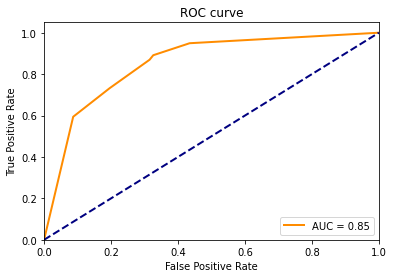

In [25]:
plot_roccurve(y_test,X_test,clf_KNN)

In [26]:
# Lets try the parameters without cross-validation:
KNN_noCV = KNeighborsClassifier(algorithm = 'ball_tree', n_neighbors= 3, p = 1, weights = 'uniform')
KNN_noCV.fit(X_train, y_train)
y_train_pred = KNN_noCV.predict(X_train)
y_test_pred = KNN_noCV.predict(X_test)
print("Train score: "+str(accuracy_score(y_train_pred,y_train)))
print("Test score: "+str(accuracy_score(y_test_pred,y_test)))

Train score: 0.8997093023255814
Test score: 0.7956521739130434


Without cross-validation results do not change.

In [27]:
np.random.seed(0)
# Training k nearest neighbors (k-NN)
t0 = time()
print("Fitting the classifier to the training set...")
param_grid = {'leaf_size':[2,30,40,50,70,100,1000]}
grid = GridSearchCV(KNeighborsClassifier(algorithm = 'ball_tree', n_neighbors= 5, p = 1, weights = 'uniform'), param_grid, cv=10)
grid.fit(X_train, y_train)
clf_KNN = grid.best_estimator_

print("Elapsed time: %0.3fs"%(time() - t0))
print("Best estimator found by grid search:")
print(grid.best_params_)

Fitting the classifier to the training set...
Elapsed time: 1.496s
Best estimator found by grid search:
{'leaf_size': 2}


Changing the leaf_size parameter typically does not have a significant effect on the results because the dataset is small.

## Support Vector Machine (SVM)

In [28]:
# from sklearn import svm
from sklearn.svm import SVC

In [29]:
# Training a Support Vector Machine (SVM)
t0 = time()
print("Fitting the classifier to the training set...")
param_grid={'C': [0.001,0.01,0.1, 1, 100,300,500],    #,700,900,1000#, 1, 1E2, 5E2       
            'degree': [0,1,2,3], #,1,2
            'kernel': ['linear', 'poly', 'rbf'], 
            'gamma' : ['scale','auto'] #[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]
           }
clf_temp = SVC(class_weight='balanced', probability=True,random_state=0)
grid = GridSearchCV(estimator=clf_temp, param_grid=param_grid, cv=10)
grid.fit(X_train, y_train)
clf_SVM = grid.best_estimator_

print("Elapsed time: %0.3fs"%(time() - t0))
print("Best estimator found by grid search:")
print(grid.best_params_)

Fitting the classifier to the training set...
Elapsed time: 925.938s
Best estimator found by grid search:
{'C': 0.01, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}


In [30]:
y_train_pred = clf_SVM.predict(X_train)
y_test_pred = clf_SVM.predict(X_test)
print("Train score: "+str(accuracy_score(y_train_pred,y_train)))
print("Test score: "+str(accuracy_score(y_test_pred,y_test)))

Train score: 0.8822674418604651
Test score: 0.8


Train confusion matrix


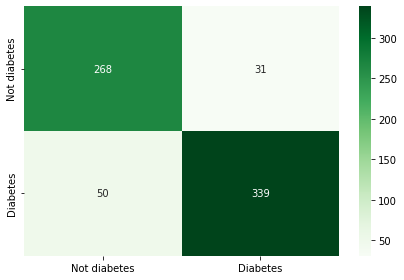

Test confusion matrix


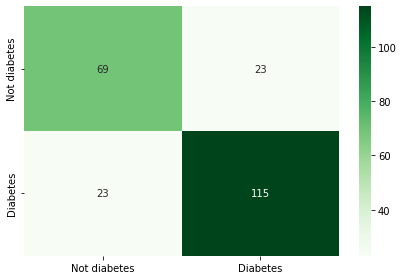

In [31]:
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

In [32]:
print('Train classification report')
print(classification_report(y_train, y_train_pred, target_names=classes))

print('Test classification report')
print(classification_report(y_test, y_test_pred, target_names=classes))

Train classification report
              precision    recall  f1-score   support

Not diabetes       0.90      0.84      0.87       318
    Diabetes       0.87      0.92      0.89       370

    accuracy                           0.88       688
   macro avg       0.88      0.88      0.88       688
weighted avg       0.88      0.88      0.88       688

Test classification report
              precision    recall  f1-score   support

Not diabetes       0.75      0.75      0.75        92
    Diabetes       0.83      0.83      0.83       138

    accuracy                           0.80       230
   macro avg       0.79      0.79      0.79       230
weighted avg       0.80      0.80      0.80       230



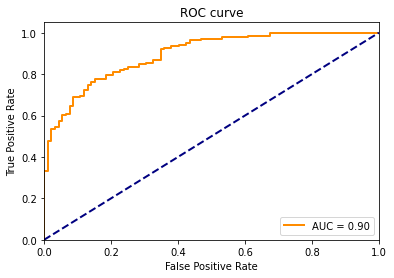

In [33]:
plot_roccurve(y_test,X_test,clf_SVM)

# Ensemble methods

A simple decision tree obtain a good performance of metrics. Next logical step will be using ensemble methods with trees.

In [34]:
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier

## Random Forest (RF)

In [35]:
t0 = time()
print("Fitting the classifier to the training set...")
# 10-fold cv with different parameters
params = {
    'n_estimators': [50, 75, 100, 125, 150, 175, 200, 225, 250]
}
clf_temp = RandomForestClassifier(random_state=0)
grid_RF = GridSearchCV(estimator=clf_temp,param_grid=params,cv=10)
grid_RF.fit(X_train,y_train)
clf_RF = grid_RF.best_estimator_
print("Elapsed time: %0.3fs"%(time() - t0))
print("Best estimator found by grid search:")
print(grid_RF.best_params_)

Fitting the classifier to the training set...
Elapsed time: 50.420s
Best estimator found by grid search:
{'n_estimators': 250}


In [36]:
y_train_pred = clf_RF.predict(X_train)
y_test_pred = clf_RF.predict(X_test)
print("Train score: "+str(accuracy_score(y_train_pred,y_train)))
print("Test score: "+str(accuracy_score(y_test_pred,y_test)))

Train score: 1.0
Test score: 0.8478260869565217


Train confusion matrix


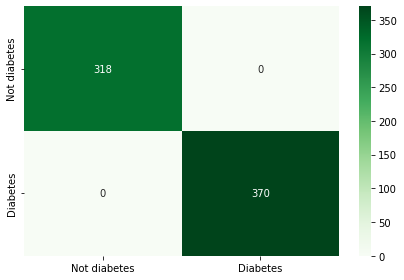

Test confusion matrix


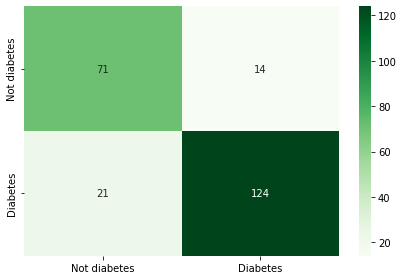

In [37]:
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

In [38]:
print('Train classification report')
print(classification_report(y_train, y_train_pred, target_names=classes))

print('Test classification report')
print(classification_report(y_test, y_test_pred, target_names=classes))

Train classification report
              precision    recall  f1-score   support

Not diabetes       1.00      1.00      1.00       318
    Diabetes       1.00      1.00      1.00       370

    accuracy                           1.00       688
   macro avg       1.00      1.00      1.00       688
weighted avg       1.00      1.00      1.00       688

Test classification report
              precision    recall  f1-score   support

Not diabetes       0.84      0.77      0.80        92
    Diabetes       0.86      0.90      0.88       138

    accuracy                           0.85       230
   macro avg       0.85      0.84      0.84       230
weighted avg       0.85      0.85      0.85       230



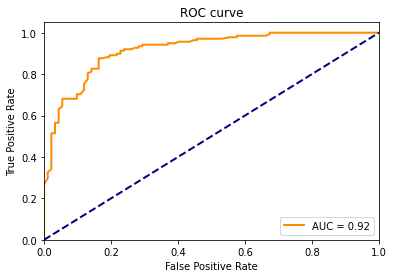

In [39]:
plot_roccurve(y_test,X_test,clf_RF)

## AdaBoost

In [40]:
t0 = time()
print("Fitting the classifier to the training set...")
# 10-fold cv with different parameters
params = {
    'n_estimators': [50, 75, 100, 125, 150, 200],
    'estimator' : [None, clf_pruned_tree, clf_SVM] 
    #KNN algorithm does not support sample weighting, required for Adaboost.
}
clf_temp = AdaBoostClassifier(random_state=0)
grid_AB = GridSearchCV(estimator=clf_temp,param_grid=params,cv=10,error_score='raise')
grid_AB.fit(X_train,y_train)
clf_AB = grid_AB.best_estimator_
print("Elapsed time: %0.3fs"%(time() - t0))
print("Best estimator found by grid search:")
print(grid_AB.best_params_)

Fitting the classifier to the training set...
Elapsed time: 688.870s
Best estimator found by grid search:
{'estimator': DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=6, max_features='sqrt', random_state=0), 'n_estimators': 125}


In [41]:
y_train_pred = clf_AB.predict(X_train)
y_test_pred = clf_AB.predict(X_test)
print("Train score: "+str(accuracy_score(y_train_pred,y_train)))
print("Test score: "+str(accuracy_score(y_test_pred,y_test)))

Train score: 1.0
Test score: 0.8652173913043478


Train confusion matrix


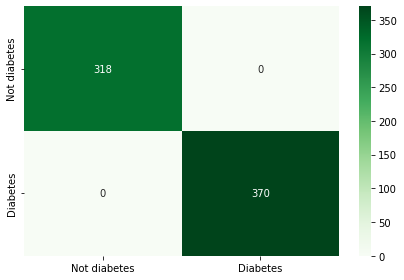

Test confusion matrix


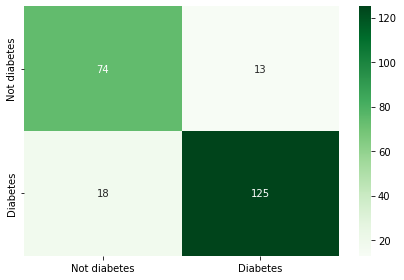

In [42]:
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

In [43]:
print('Train classification report')
print(classification_report(y_train, y_train_pred, target_names=classes))

print('Test classification report')
print(classification_report(y_test, y_test_pred, target_names=classes))

Train classification report
              precision    recall  f1-score   support

Not diabetes       1.00      1.00      1.00       318
    Diabetes       1.00      1.00      1.00       370

    accuracy                           1.00       688
   macro avg       1.00      1.00      1.00       688
weighted avg       1.00      1.00      1.00       688

Test classification report
              precision    recall  f1-score   support

Not diabetes       0.85      0.80      0.83        92
    Diabetes       0.87      0.91      0.89       138

    accuracy                           0.87       230
   macro avg       0.86      0.86      0.86       230
weighted avg       0.86      0.87      0.86       230



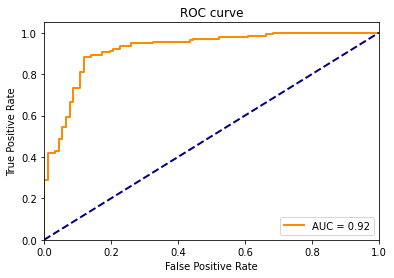

In [44]:
plot_roccurve(y_test,X_test,clf_AB)

## Gradient Boosting

In [45]:
t0 = time()
print("Fitting the classifier to the training set...")
# 10-fold cv with different parameters
params = {
    'n_estimators': [15,20,25,50, 75, 100, 125, 150, 200],
    'init' : [None, clf_pruned_tree, clf_SVM, KNN_noCV]
    # KNN_noCV used instead of clf_KNN because it has less neighbors.
    # Maximum depth of the trees or the number of neighbors in KNN...
    #... should be small values to avoid overfitting in Gradient Boosting.
}
clf_temp = GradientBoostingClassifier(random_state=0)
grid_GB = GridSearchCV(estimator=clf_temp,param_grid=params,cv=10)
grid_GB.fit(X_train,y_train)
clf_GB = grid_GB.best_estimator_
print("Elapsed time: %0.3fs"%(time() - t0))
print("Best estimator found by grid search:")
print(grid_GB.best_params_)

Fitting the classifier to the training set...
Elapsed time: 99.187s
Best estimator found by grid search:
{'init': SVC(C=0.01, class_weight='balanced', degree=2, kernel='poly', probability=True,
    random_state=0), 'n_estimators': 50}


In [46]:
y_train_pred = clf_GB.predict(X_train)
y_test_pred = clf_GB.predict(X_test)
print("Train score: "+str(accuracy_score(y_train_pred,y_train)))
print("Test score: "+str(accuracy_score(y_test_pred,y_test)))

Train score: 0.940406976744186
Test score: 0.8695652173913043


Train confusion matrix


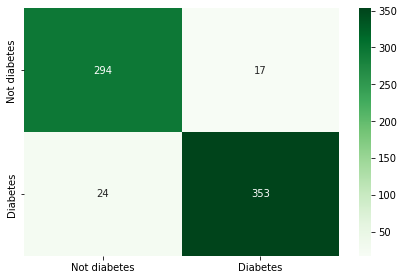

Test confusion matrix


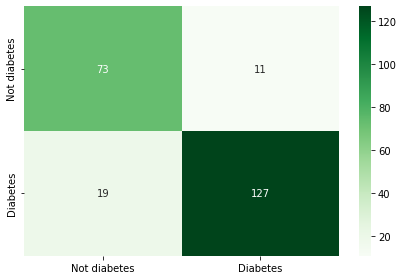

In [47]:
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

In [48]:
print('Train classification report')
print(classification_report(y_train, y_train_pred, target_names=classes))

print('Test classification report')
print(classification_report(y_test, y_test_pred, target_names=classes))

Train classification report
              precision    recall  f1-score   support

Not diabetes       0.95      0.92      0.93       318
    Diabetes       0.94      0.95      0.95       370

    accuracy                           0.94       688
   macro avg       0.94      0.94      0.94       688
weighted avg       0.94      0.94      0.94       688

Test classification report
              precision    recall  f1-score   support

Not diabetes       0.87      0.79      0.83        92
    Diabetes       0.87      0.92      0.89       138

    accuracy                           0.87       230
   macro avg       0.87      0.86      0.86       230
weighted avg       0.87      0.87      0.87       230



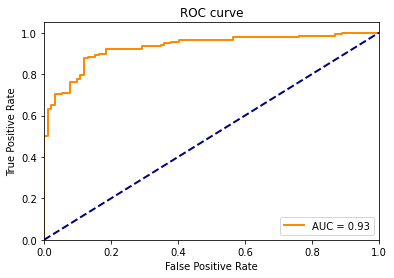

In [49]:
plot_roccurve(y_test,X_test,clf_GB)

Brief discussion:

Source: https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28

Lot of metrics were required by all of the machine learning models in this notebook. Attendding to the real-world scenario of a heart disease analysis, the most important metric is the precision of the class Heart Disease ('HeartDisease' = 1), followed by the recall of the same class, therefore f1-score would be the best metric that summarizes the two previous ones. **Gradient Boosting has the best metrics for the real-world scenario.**

If you evaluate the quality of models, you should look at the overall accuracy on test and AUC-ROC metrics for new data, i.e. the test data. It is also important to monitor the model's accuracy on the training data to avoid overfitting, which means that the model fits too closely to the training data and cannot generalize well to unseen data. **Better quality model is Gradient Boosting.**

# Bias and variance

Bias and variance are two key components that you must consider when developing any good, accurate machine learning model.

-  Bias creates consistent errors in the ML model, which represents a simpler ML model that is not suitable for a specific requirement.
-  On the other hand, variance creates variance errors that lead to incorrect predictions seeing trends or data points that do not exist.

Generally, the goal is to keep bias as low as possible while introducing acceptable levels of variances. This can be done either by increasing the complexity or increasing the training data set.
Source: https://www.bmc.com/blogs/bias-variance-machine-learning/

Therefore, a simple decision tree will have high bias and low variance. Support Vector Machines (SVM) are generally considered to have a lower bias and a higher variance, as they are able to model complex non-linear decision boundaries. K-Nearest Neighbors (KNN) is considered to have a higher bias and a lower variance, as it does not make any assumptions about the underlying data distribution and can be used for both linear and non-linear problems.

SVM and KNN methods can have higher variance and lower bias compared to a single decision tree. This is because both SVM and KNN models can capture complex relationships between the features and the target variable, which can lead to overfitting and higher variance. However, by tuning the hyperparameters and regularization, we can reduce the variance and improve the bias-variance tradeoff of these models.

Bagging and boosting methods can reduce the variance of high-variance models like decision trees by aggregating the predictions of multiple models. Bagging can reduce the variance without significantly affecting the bias, while boosting can reduce both the bias and variance. However, the effectiveness of these methods depends on the quality of the base models and the hyperparameters used in the ensemble methods.

Both bias and variance of our models (best models found by GridSearhCV) can be calculated in Python using a library called mlxtend with a function called bias_variance_decomp. Also calculates the average expected loss, which is the average error or loss that is expected to be encountered by the model on new or unseen data. It is calculated as the sum of bias and variance. A low expected loss indicates that the model is performing well and generalizing to new data.

In [50]:
# !pip install -q mlxtend

In [51]:
from mlxtend.evaluate import bias_variance_decomp

In [52]:
# Display Bias and Variance
def bias_var(clf):
    # Getting Bias and Variance
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
    clf, X_train.values, y_train.values, X_test.values, y_test.values, 
    loss='0-1_loss',
    random_seed=0,
    num_rounds=1000)
    # Display Bias and Variance
    print(f'Average Expected Loss: {round(avg_expected_loss, 4)}')
    print(f'Average Bias: {round(avg_bias, 4)}')
    print(f'Average Variance: {round(avg_var, 4)}')

Best pruned tree found:

In [53]:
bias_var(clf_pruned_tree)

Average Expected Loss: 0.1929
Average Bias: 0.1609
Average Variance: 0.1156


Best KNN found:

In [54]:
bias_var(clf_KNN)

Average Expected Loss: 0.2031
Average Bias: 0.2
Average Variance: 0.0641


Best SVM found:

In [55]:
bias_var(clf_SVM)

Average Expected Loss: 0.2029
Average Bias: 0.2
Average Variance: 0.0105


Best Random Forest found:

In [56]:
bias_var(clf_RF)

Average Expected Loss: 0.1542
Average Bias: 0.1522
Average Variance: 0.031


Best AdaBoost found:

In [57]:
bias_var(clf_AB)

Average Expected Loss: 0.1423
Average Bias: 0.1304
Average Variance: 0.0302


Best Gradient Boosting found:

In [58]:
bias_var(clf_GB)

Average Expected Loss: 0.1432
Average Bias: 0.1348
Average Variance: 0.0334


**AdaBoosting has the best bias and variance values.**